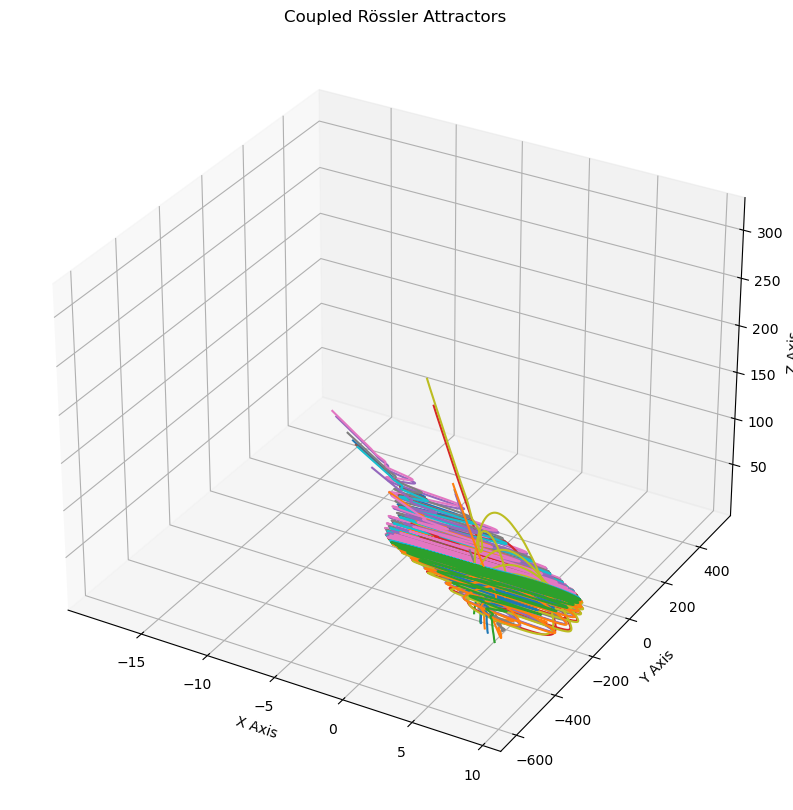

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import PRA as pra
import MVRA as mvra
import matplotlib.pyplot as plt
import mne
from mne_connectivity import spectral_connectivity_epochs
import seaborn as sns

def rossler_attractor(t, Y, a, b, c, coupling_matrix):
    n = len(Y) // 3 # Number of oscillators
    Y = Y.reshape((n, 3))
    dYdt = np.zeros_like(Y)
    for i in range(n):
        x, y, z = Y[i]
        sum_coupled_x = np.sum(coupling_matrix[i] * (Y[:, 0] - x)) # Example linear coupling on x
        dYdt[i, 0] = -y - z + sum_coupled_x
        dYdt[i, 1] = x + a * y
        dYdt[i, 2] = b + z * (x - c)
    return dYdt.flatten()
# Parameters
a, b, c = 0.1, 0.15, 4.7
n_oscillators = 33
n_signals = n_oscillators * 3
coupling_strength = 1.0
coupling_matrix = coupling_strength * (np.ones((n_oscillators, n_oscillators)) - np.eye(n_oscillators))


sampling_rate = 250
seconds = 100

# Expand this to a 99x99 matrix where only x components are coupled
ground_truth= np.zeros((n_signals, n_signals))
for i in range(n_oscillators):
    for j in range(n_oscillators):
        ground_truth[3*i, 3*j] = coupling_matrix[i, j]  # Place the coupling strength in the matrix

# Initial conditions and time span
initial_conditions = np.random.rand(n_oscillators * 3)
t_span = (0, seconds)
t_eval = np.linspace(t_span[0], t_span[1], sampling_rate*seconds)
# Solve the coupled system
signals = solve_ivp(rossler_attractor, t_span, initial_conditions, args=(a, b, c, coupling_matrix), t_eval=t_eval, method='RK45')
# Plot the results
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
for i in range(n_oscillators):
    ax.plot(signals.y[i*3], signals.y[i*3+1], signals.y[i*3+2])
    ax.set_title('Coupled Rössler Attractors')
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
plt.show()

In [2]:
## simulated data
ch_names = ["Ch{}".format(i+1) for i in range(n_signals)]

#ch_names = ["A", "B", "C"]
#sim_data = np.array([solution.y[1], solution.y[4], solution.y[7]])
sim_data = np.array(signals.y)
#sim_data = np.array(solution.y[:10])
info = mne.create_info(ch_names=ch_names, ch_types=["eeg"]*n_signals, sfreq=sampling_rate)
simulated_raw = mne.io.RawArray(sim_data, info)
epochs = mne.make_fixed_length_epochs(simulated_raw, duration=25.0)

Creating RawArray with float64 data, n_channels=99, n_times=25000
    Range : 0 ... 24999 =      0.000 ...    99.996 secs
Ready.
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated


In [3]:
#PRA
pra_mat = pra.PRA(epochs.get_data(),sampling_frequency=sampling_rate,num_reservoir=10)

#MVRA
mvra_mat = mvra.MVRA(epochs.get_data(),sampling_frequency=sampling_rate,num_reservoir=3)

Using data from preloaded Raw for 4 events and 6250 original time points ...
0 bad epochs dropped


  0%|          | 0/4 [00:00<?, ?it/s]

Using data from preloaded Raw for 4 events and 6250 original time points ...


  0%|          | 0/4 [00:00<?, ?it/s]

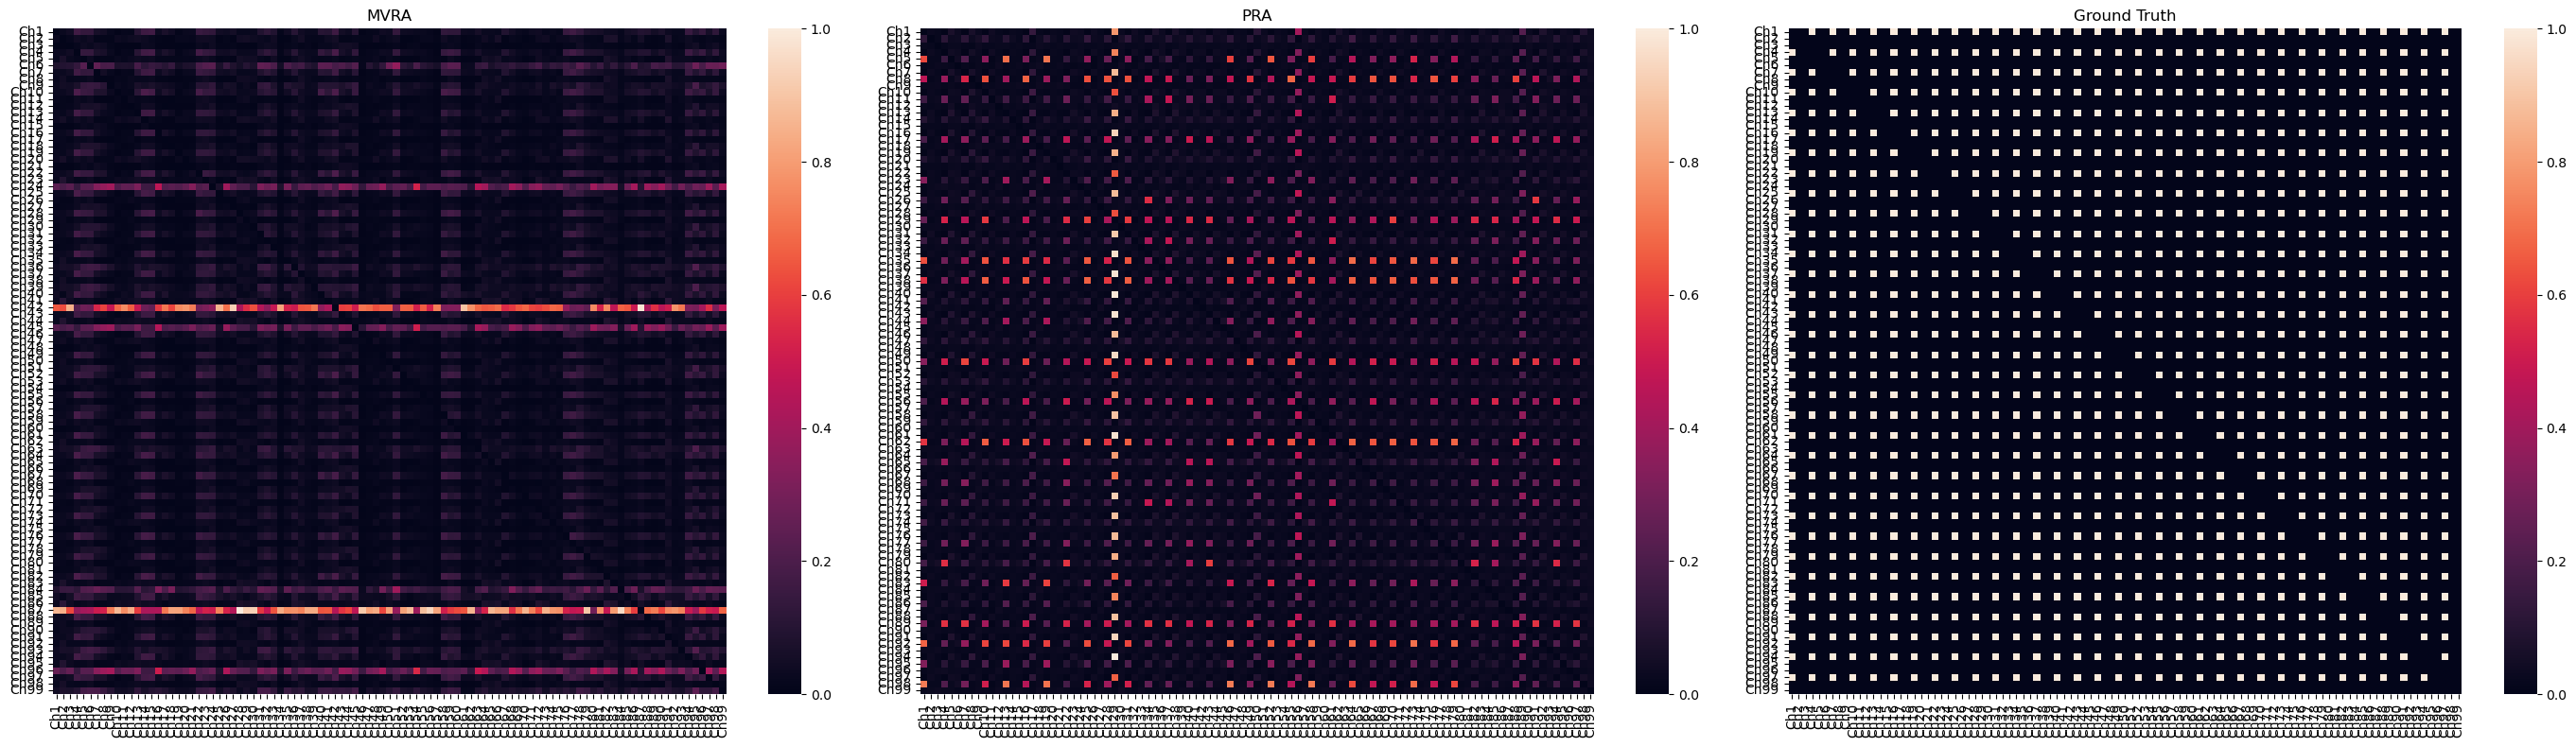

In [4]:
ch_names = ["Ch{}".format(i+1) for i in range(n_signals)]
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(28,8))
sns.heatmap(mvra_mat.squeeze(), annot=False, xticklabels=ch_names, yticklabels=ch_names, ax=ax1)
ax1.set_title('MVRA')

sns.heatmap(pra_mat, annot=False, xticklabels=ch_names, yticklabels=ch_names, ax=ax2)
ax2.set_title('PRA')

# Plotting the ground truth connectivity matrix
#plt.figure(figsize=(10, 8))
sns.heatmap(ground_truth, annot=False, xticklabels=ch_names, yticklabels=ch_names, ax=ax3)
ax3.set_title('Ground Truth')

fig.tight_layout()
plt.savefig('rossle_data_all_time.pdf')